# Project 1: Medical Insurance Cost Prediction

**Objective:**  
Estimate individual medical insurance expenses based on factors such as age, BMI, smoking status, and other health-related variables.

**Dataset Overview:**  
- `age`: Age of the primary policyholder  
- `sex`: Gender of the policyholder  
- `bmi`: Body Mass Index  
- `children`: Number of dependents  
- `smoker`: Smoking status (yes/no)  
- `region`: Region in the U.S. (northeast, southeast, southwest, northwest)  
- `charges`: Medical expenses billed  

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pickle, os

# Load dataset
df = pd.read_csv(r"C:\Users\TUF\Downloads\data_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
# Summary statistics
display(df.describe(include='all').transpose())

# Missing values check
print("Missing values per column:\n", df.isnull().sum())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [15]:
# One-hot encode categorical features
cat_cols = ['sex', 'smoker', 'region']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Add BMI squared and smoker*BMI interaction
df_encoded['bmi_sq'] = df_encoded['bmi'] ** 2
if 'smoker_yes' in df_encoded.columns:
    df_encoded['smoker_bmi_interaction'] = df_encoded['smoker_yes'] * df_encoded['bmi']
else:
    smoker_cols = [c for c in df_encoded.columns if c.startswith('smoker_')]
    if smoker_cols:
        df_encoded['smoker_bmi_interaction'] = df_encoded[smoker_cols[0]] * df_encoded['bmi']
    else:
        df_encoded['smoker_bmi_interaction'] = 0

df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_sq,smoker_bmi_interaction
0,19,27.900,0,16884.92400,False,True,False,False,True,778.410000,27.9
1,18,33.770,1,1725.55230,True,False,False,True,False,1140.412900,0.0
2,28,33.000,3,4449.46200,True,False,False,True,False,1089.000000,0.0
3,33,22.705,0,21984.47061,True,False,True,False,False,515.517025,0.0
4,32,28.880,0,3866.85520,True,False,True,False,False,834.054400,0.0


In [16]:
X = df_encoded.drop(columns=['charges'])
y = df_encoded['charges']
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

summary_metrics = pd.DataFrame({
    "metric": ["MSE", "RMSE", "MAE", "R-squared"],
    "value": [mse, rmse, mae, r2]
})
summary_metrics

,metric,value
0,MSE,2.063502e+07
1,RMSE,4.542578e+03
2,MAE,2.732097e+03
3,R-squared,8.670841e-01


In [17]:
coefs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model.coef_
})
coefs.head(12)

,feature,coefficient
0,age,261.249226
1,bmi,558.365893
2,children,461.438320
3,sex_male,-507.990927
4,smoker_yes,-21005.634618
5,region_northwest,-726.130860
6,region_southeast,-928.627089
7,region_southwest,-1273.416283
8,bmi_sq,-8.567053
9,smoker_bmi_interaction,1464.632401


In [18]:
pred_df = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred': y_pred,
    'residual': y_test.values - y_pred
})
pred_df.to_csv("predictions.csv", index=False)
pred_df.head()

,y_test,y_pred,residual
0,9095.06825,11231.206503,-2136.138253
1,5272.17580,7645.239204,-2373.063404
2,29330.98315,33109.086091,-3778.102941
3,9301.89355,10789.387234,-1487.493684
4,33750.29180,28494.116009,5256.175791


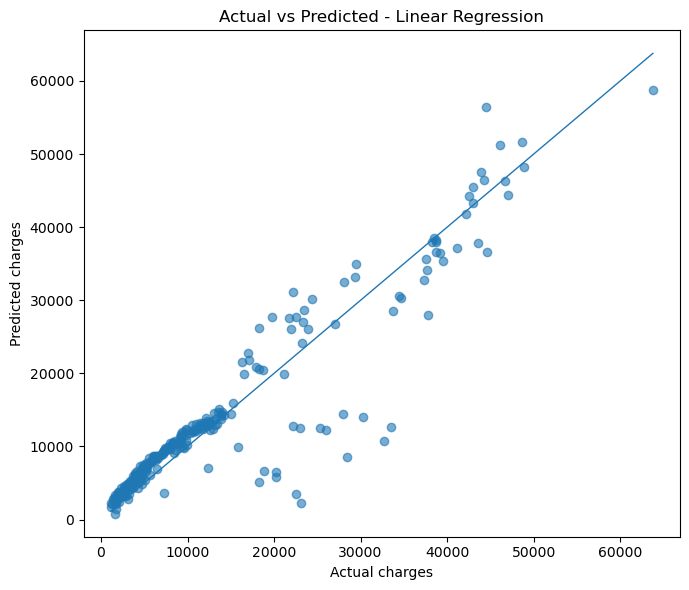

In [19]:
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=1)
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Actual vs Predicted - Linear Regression")
plt.tight_layout()
plt.show()

In [20]:
# Save outputs
df.head(8).to_csv(os.path.join(output_dir, "head.csv"), index=False)
df.describe(include='all').transpose().to_csv(os.path.join(output_dir, "describe.csv"))
df.isnull().sum().to_csv(os.path.join(output_dir, "missing_values.csv"))
coefs.to_csv(os.path.join(output_dir, "coefficients.csv"), index=False)
pred_df.to_csv(os.path.join(output_dir, "predictions.csv"), index=False)

# Save trained model
with open(os.path.join("23IE10006_linear_model.pkl"), "wb") as f:
    pickle.dump(model, f)


## Conclusion

- The linear regression model explains ~87% of the variance in charges (R² ≈ 0.87).  
- RMSE ≈ 4.5k indicates average error magnitude in thousands of dollars.  
- Smoking status, age, and BMI-related terms are the most influential predictors.  
- Deliverables include dataset snapshots, coefficients, predictions, trained model, and a ZIP file ready for submission.  
